In [44]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy.special import expit
from research.logreg import (
    fit_and_score, show_pred, make_train_test, classification_report, make_pipeline,
    PolynomialFeatures, StandardScaler, pred_grid, make_grid
)
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
train_test = X_train, X_test, y_train, y_test = make_train_test()
pf = PolynomialFeatures(degree=3)
ss = StandardScaler()
tform = make_pipeline(pf, ss)
tform.fit(X_train)
nfeatures = tform.named_steps['polynomialfeatures'].powers_.shape[0]
X_tf = tform.transform(X_train)

In [64]:
with pm.Model() as logreg:
    betas = pm.Normal('beta', mu=0, sd=20, shape=nfeatures)
    logit = (betas * X_tf).sum(axis=1)
    obs = pm.Bernoulli('obs', logit_p=logit, observed=y_train)
    trace = pm.sample(500, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:44<00:00, 225.40draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/Users/kusmith/miniconda3/envs/research-3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


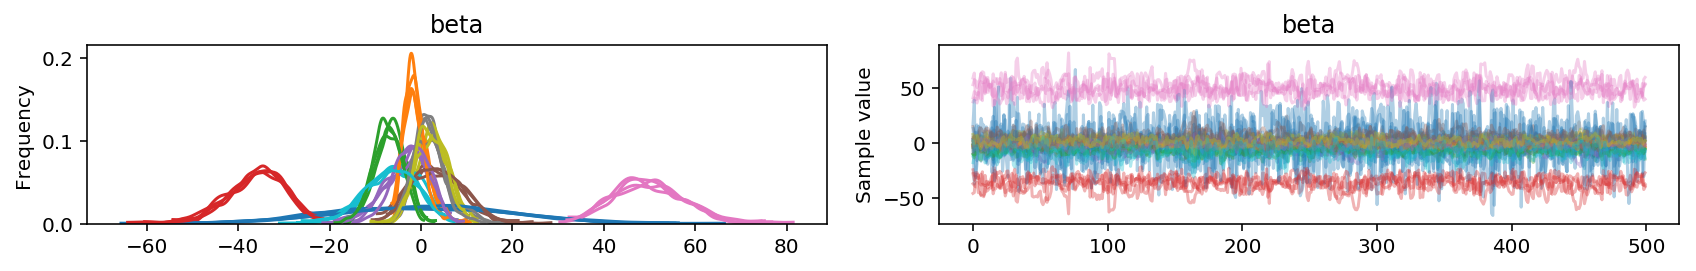

In [65]:
pm.traceplot(trace);

In [66]:
pm.summary(trace)

mean         sd  mc_error    hpd_2.5   hpd_97.5        n_eff  \
beta__0  -0.114207  18.949977  0.468163 -37.718700  35.129025  1705.041745   
beta__1  -1.243905   2.493814  0.123310  -5.465229   3.803036   269.363984   
beta__2  -7.043705   3.336741  0.145539 -13.309106  -0.733518   431.770941   
beta__3 -36.201811   6.413667  0.293777 -48.076543 -24.060818   349.988301   
beta__4  -2.934988   4.562209  0.233121 -12.189378   5.033149   288.443762   
beta__5   3.538817   5.654744  0.245162  -6.484352  14.532764   455.688454   
beta__6  49.907342   7.830661  0.314931  35.456578  64.511502   525.562391   
beta__7   2.016082   3.489039  0.170490  -4.270434   9.471209   279.503565   
beta__8   2.210774   3.436758  0.152085  -4.273038   8.672725   419.278363   
beta__9  -6.637076   5.781953  0.219573 -18.163178   3.303773   629.451466   

             Rhat  
beta__0  0.999911  
beta__1  1.007973  
beta__2  1.003695  
beta__3  1.002157  
beta__4  1.007413  
beta__5  1.003935  
beta__6  1.001023  
beta__7  1.006225  
beta__8  1.003572  
beta__9  1.003612

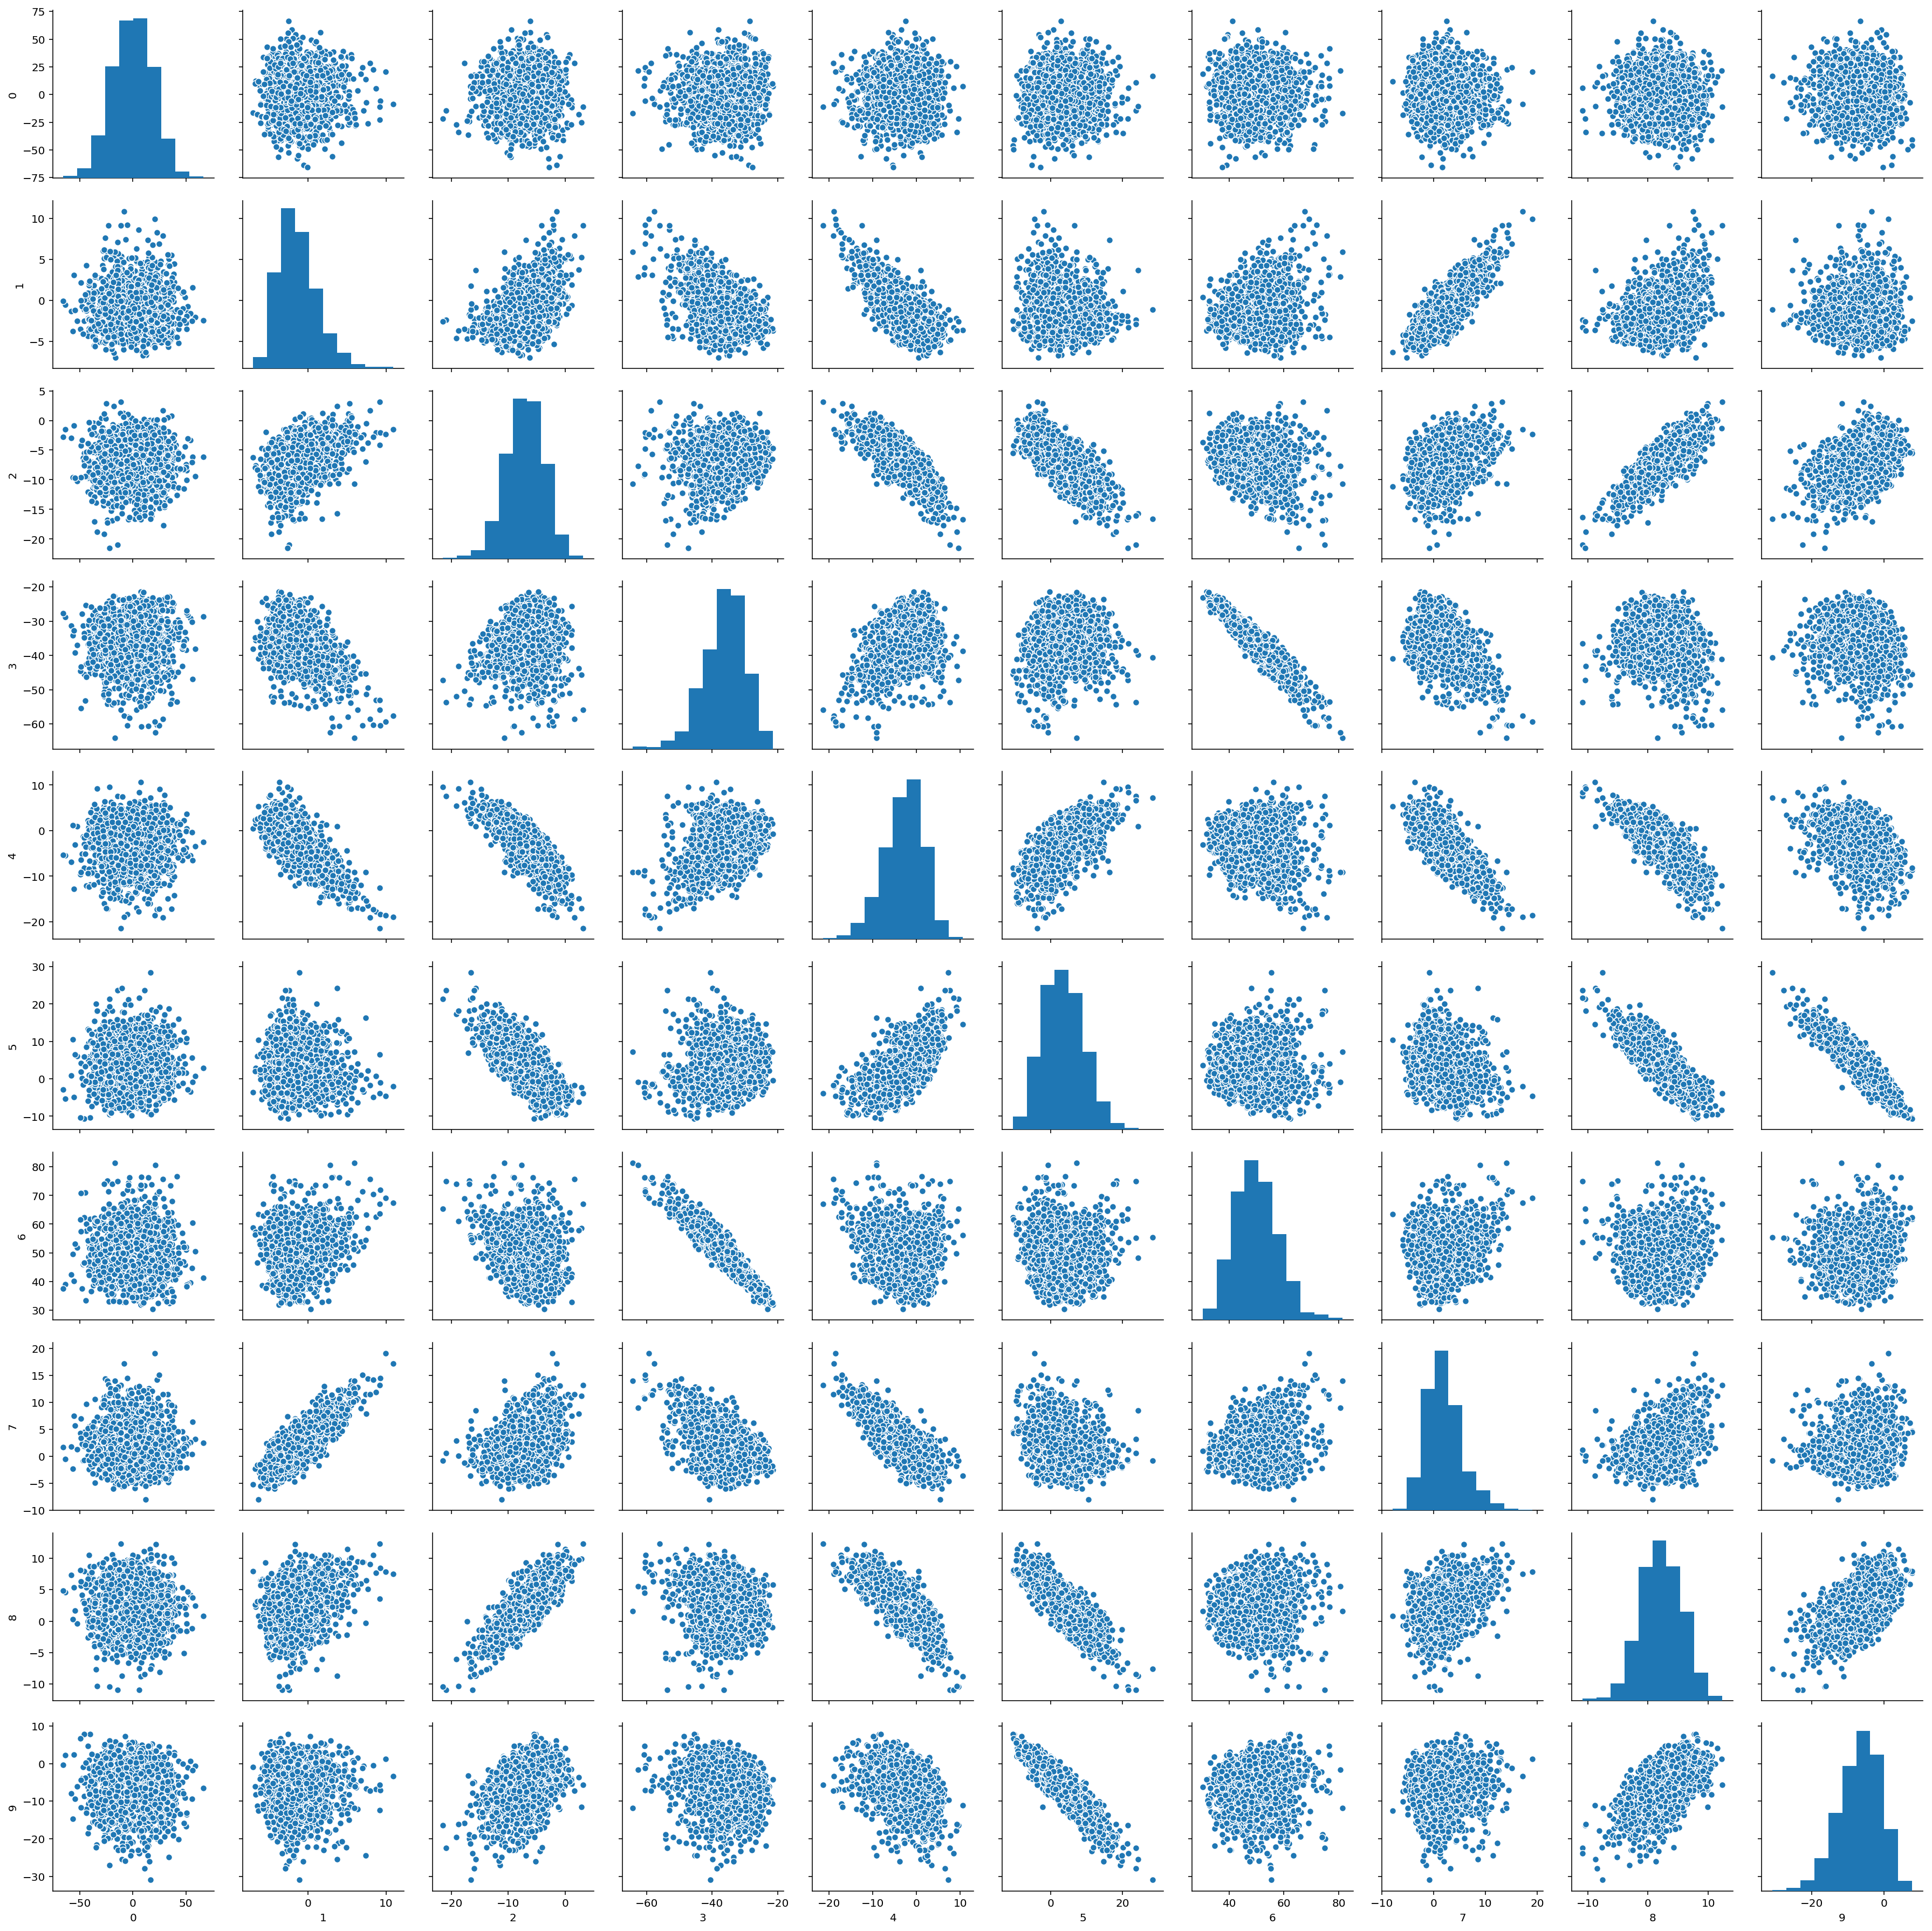

In [67]:
betas = trace.get_values('beta')
betas_df = pd.DataFrame(betas)
sns.pairplot(betas_df);

In [76]:
def posterior_logits(betas, X):
    return (betas[np.newaxis, ...] * X[:, np.newaxis, ...]).sum(axis=-1)

def pred_grid_bayes(betas, tform, x_min, x_max, y_min, y_max, n):
    x_grid, y_grid, xy_flat = make_grid(x_min, x_max, y_min, y_max, n)
    xy_tf = tform.transform(xy_flat)
    plogits = posterior_logits(betas, xy_tf)
    exps = expit(plogits)
    scores = exps.mean(axis=1)
    scores_sd = exps.std(axis=1)
    return x_grid, y_grid, scores.reshape(x_grid.shape), scores_sd.reshape(x_grid.shape)

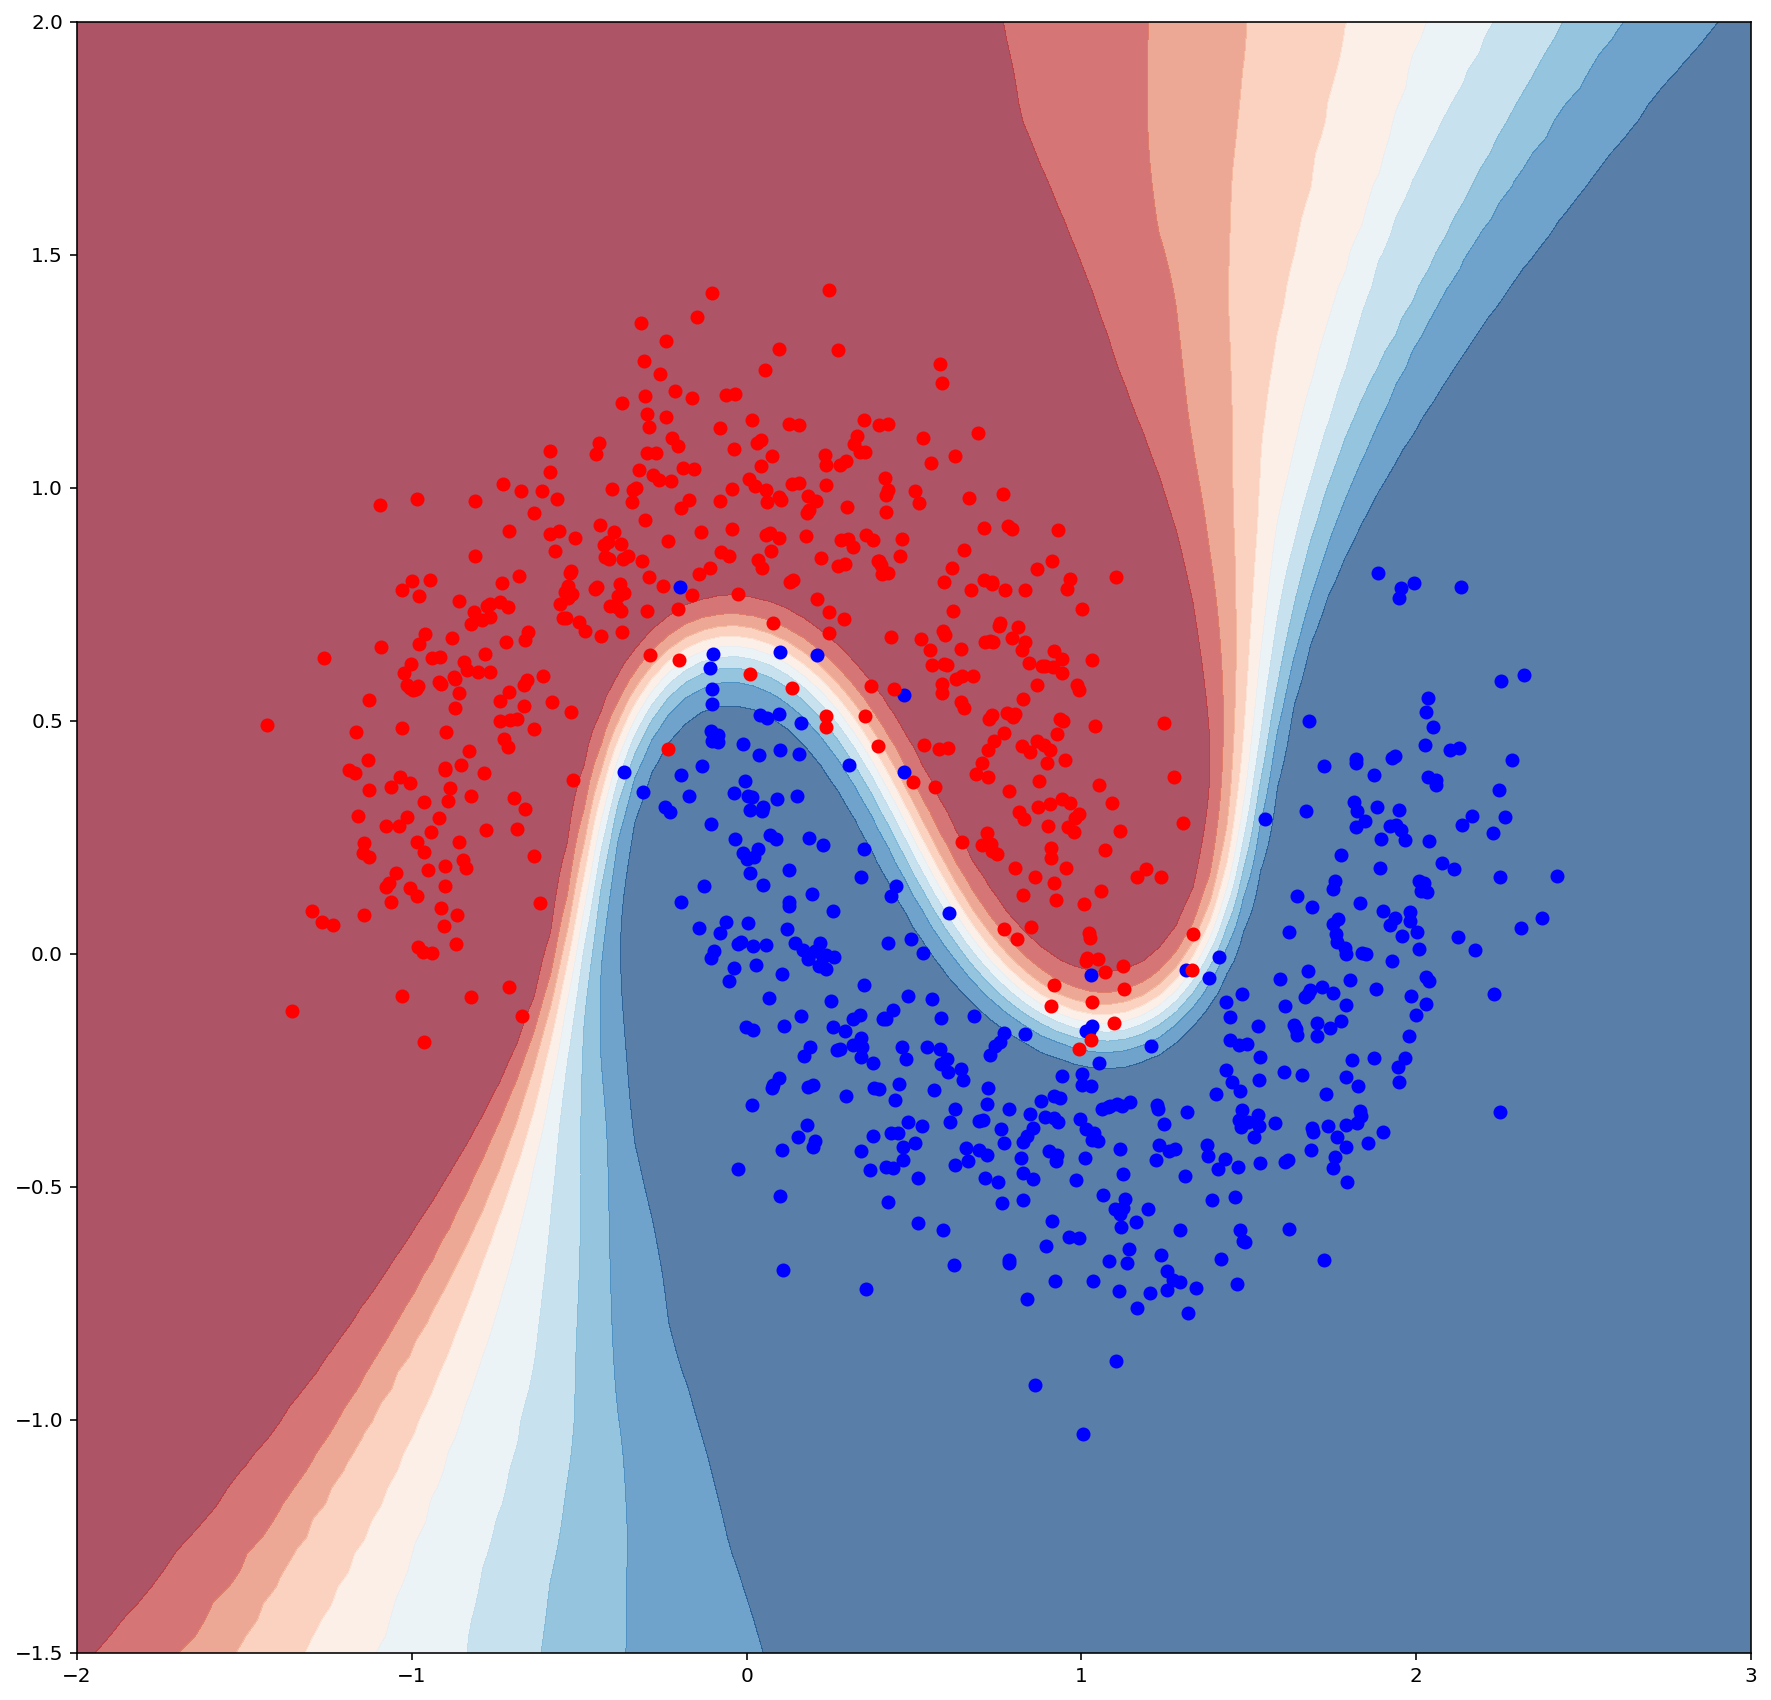

In [77]:
lrbt = -2.0, 3.0, -1.5, 2.0
x_grid, y_grid, scores, scores_sd = pred_grid_bayes(betas[::10], tform, *lrbt, 100)
show_pred(X_train, y_train, x_grid, y_grid, scores)

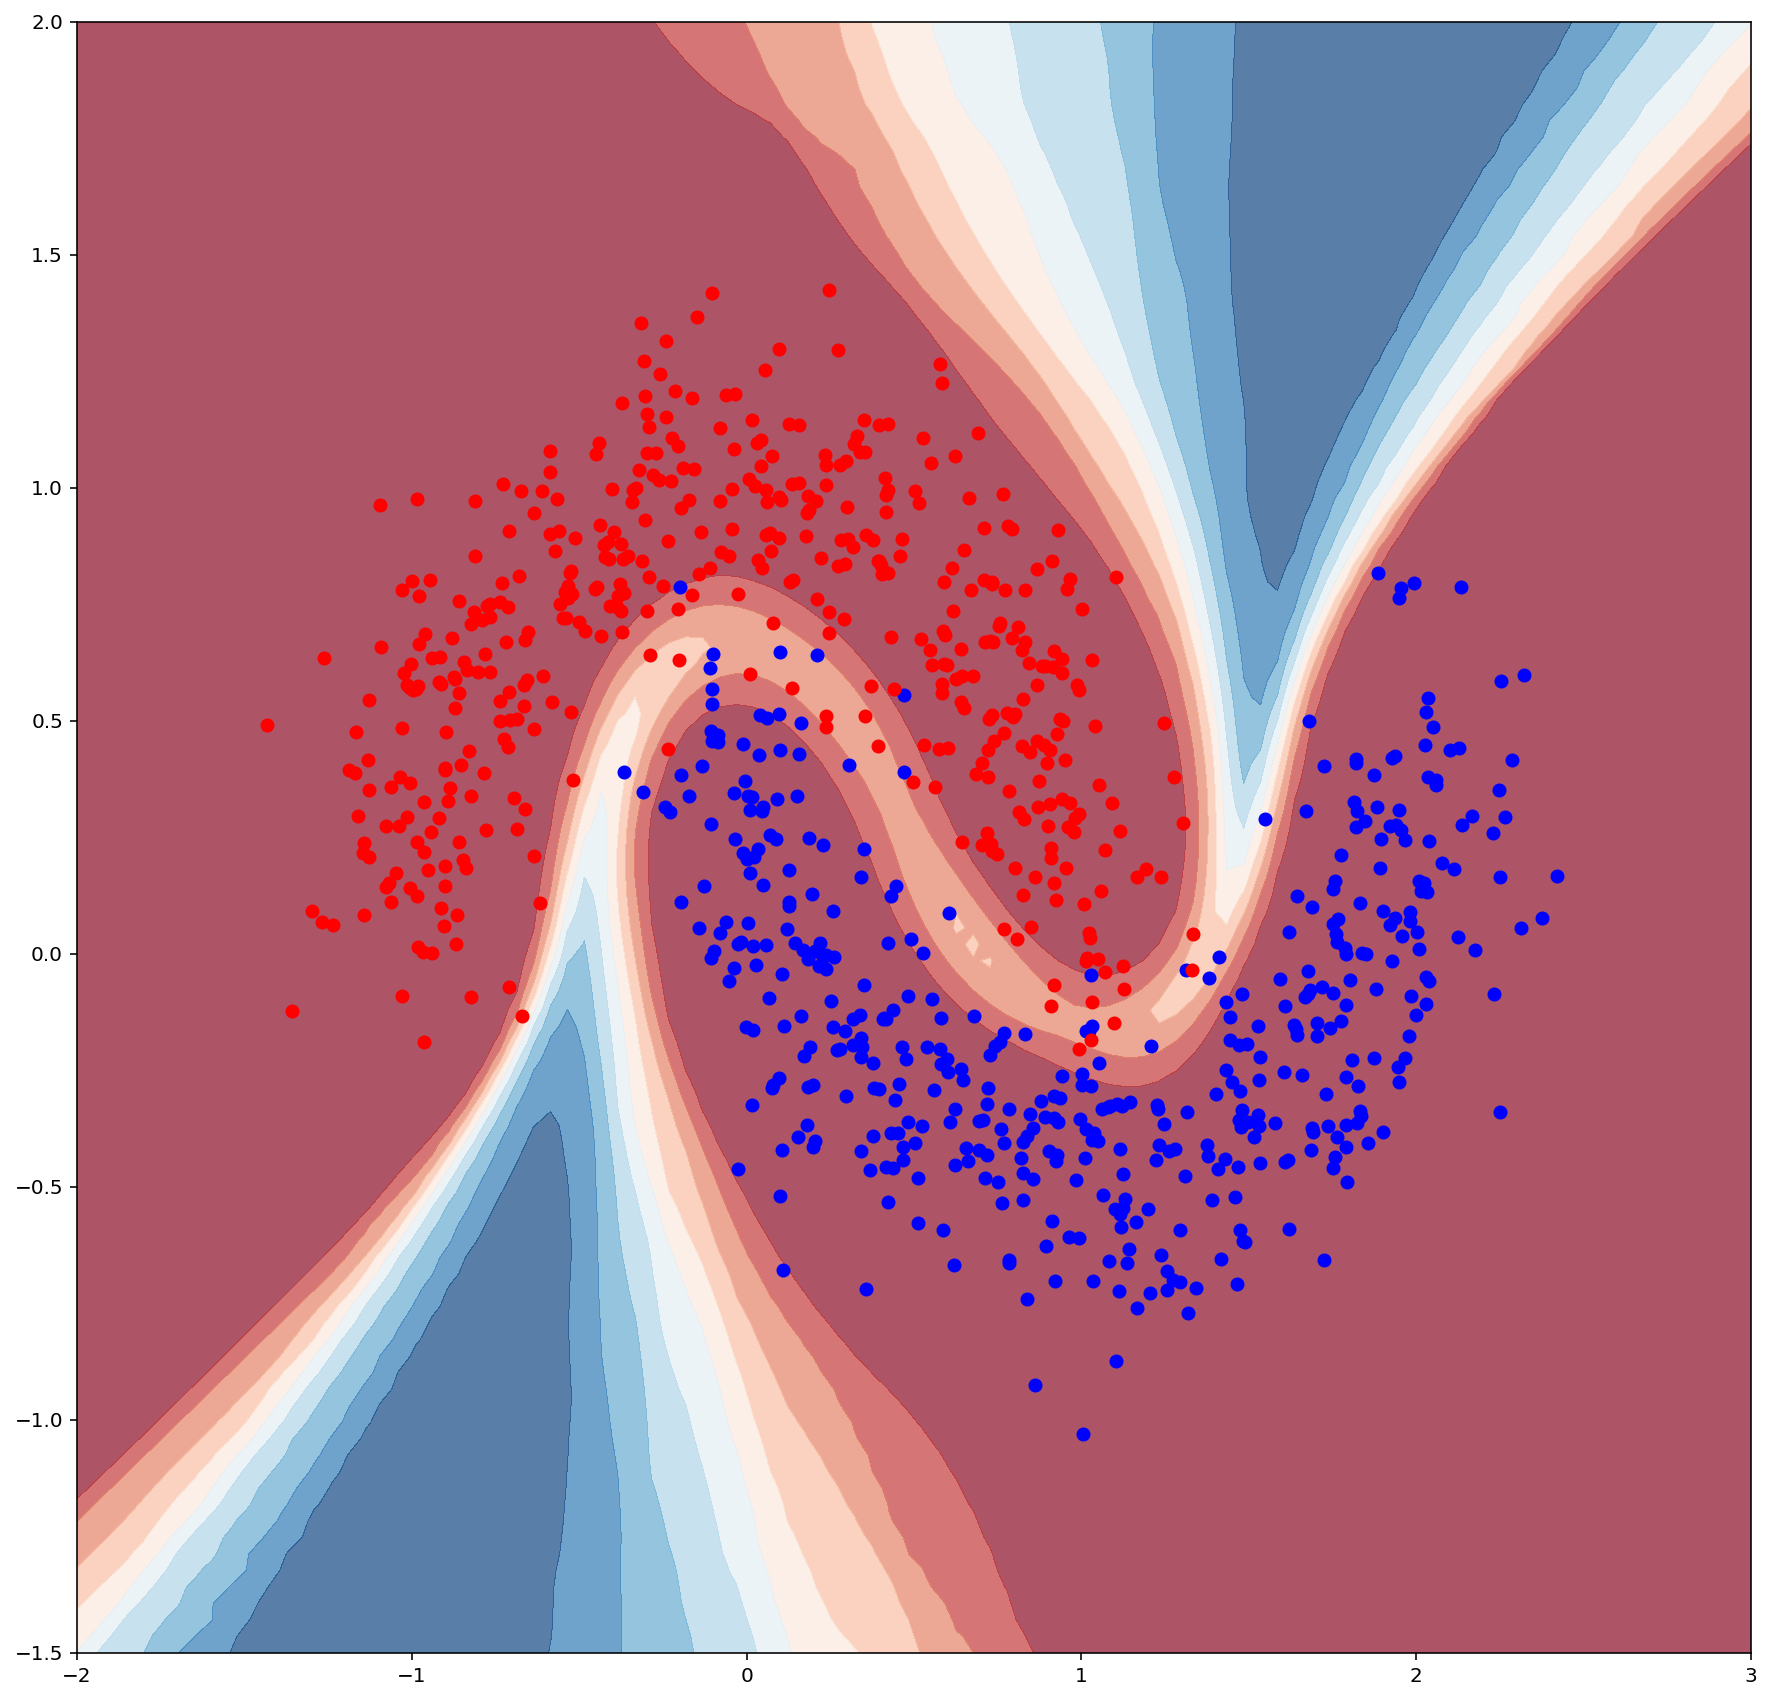

In [78]:
show_pred(X_train, y_train, x_grid, y_grid, scores_sd)